# ConvNets

In this notebook, we will implement the forward and backward propagation for CONV+POOL layers in numpy. These form the building blocks of convolutional neurals network which can be broken down in the followning tasks:

convolution layer:
- zero padding
- convolve window
- forward convolution
- backward convolution

pooling layer:
- forward pooling
- mask
- sharing value
- backward pooling

Each forward operation is matched to a backward operation ; a cache is used to store parameters to compute gradients during backprop.

> **Instructions:** Ensure your Python environment is setup with the following additional packages: 
>
> - `t7utils.py` contains unit tests to check your code and some helper functions 

In [2]:
# Package imports
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import t7utils as t7

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

%load_ext autoreload
%autoreload 2

**Notation**:

- $n_H$, $n_W$ and $n_C$: height, width and channel count of a given layer
- lowerscript $i$: $i^{th}$ refers to the $i^{th}$ vector entry
- superscript $[k]$ refers to an object of the $k^{th}$ layer 
- superscript $(i)$ refers object from the $i^{th}$ example. 


## A. Convolutional Layer Foward Propagation ##

### 1. Zero Padding ###

A convolution layer (CONV) transforms an input tensor into an output tensor of different size. For 2D data such as images, tensor dimensions are generally $n_H \times n_W \times n_C$. A first step consists in zero padding the input volume. This permits to use a CONV layer without reducing the width and height of the output volume. This is important when considering deeper networks as each CONV will shrink width/height. A special case is the "same" convolution where width/height are preserved after convolution (padding is set to 1/2 of the kernel size reduced by 1). Padding helps preserving information at the border of an image. Without padding, fewer values in the next activation maps would be affected by pixels at the edges.

<img src="figs/zero-padding.png" style="width: 800px;"/>
<caption><center>**Figure 1:** Zero-padding </center></caption>

> <font color='darkgreen'>**Exercise 1:**</font> Complete the following function to zero-pad the batch of examples X with zeros as illustrated in Figure 1. Hint: Use [np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) to pad input tensor e.g. if you want to zero-pad `X` of shape $(2000, 32, 32, 3)$,  
> ```python
Y = np.pad(X, ((0,0), (2,2), (2,2), (0,0)), 'constant')
```
> will result in tensor or shape $(2000, 34, 34, 3)$.

In [3]:
# Zero-padding
def zero_pad(X, pad):
    """
    Zero-pad input tensor X, where padding is applied to height 
    and width as shown in Figure 1
    
    Argument:
    X -- a numpy array of shape (n, n_H, n_W, n_C)
    pad -- integer, amount of padding around height and width
    
    Returns:
    X_pad -- padded numpy array of shape (n, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
    
    ### INPUT YOUR CODE HERE ### (1 line)
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant')
    ### END OF YOUR CODE SEGMENT ### 
    
    return X_pad

X.shape = (32, 8, 8, 3)
X_pad.shape = (32, 12, 12, 3)


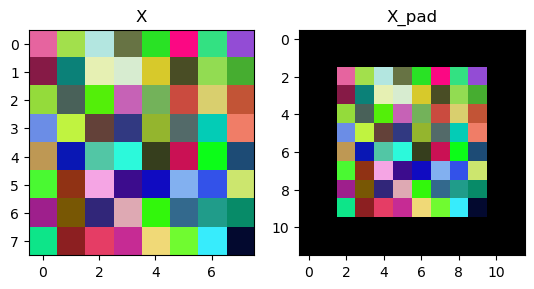

In [4]:
# testing
X = t7.zero_pad_test()
print("X.shape = {}".format(X.shape))
X_pad = zero_pad(X, 2)
print("X_pad.shape = {}".format(X_pad.shape))

_, figs = plt.subplots(1, 2)
figs[0].set_title('X')
figs[1].set_title('X_pad')
figs[0].imshow(X[0,:,:,:])
figs[1].imshow(X_pad[0,:,:,:])
figs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

> ***Expected Output:***
>
> `X.shape = (32, 8, 8, 3)
X_pad.shape = (32, 12, 12, 3)`

### 2. Convolution Step (Window Correlation) ###

Let's implement a single step of convolution by applying the filter kernel to a slice of the previous activation and corresponding to a single position of the input. The convolutional output will then be obtained by applying this single step at every position of the input.


<img src="figs/convolution.png" style="width: 350px;"/>
<caption><center>**Figure 2:** Convolution operation with a kernel of $3\times 3$ with<br/> a stride (step of sliding window) of 3 assuming zero bias</center></caption>

Each value in the left matrix corresponds to a single pixel value. We convolve a $3\times 3$ filter with the image by multiplying its values element-wise, summing up and adding a bias. 

> <font color='darkgreen'>**Exercise 2:**</font> Complete the following function to implement a single convolution step corresponding to applying a filter to one position and resulting in a single scalar output.

In [5]:
# Single convolution step
def conv_step(a_prev_slice, W, b):
    """
    Apply conv filter (W, b) on single slice
    
    Arguments:
    a_prev_slice -- input slice of shape (n_f, n_f, n_C_prev)
    W -- weight matrix of shape (n_f, n_f, n_C_prev)
    b -- bias scalar
    
    Returns:
    z -- scalar
    """
   
    ### INPUT YOUR CODE HERE ### (1 line)
    z = np.sum(a_prev_slice * W) + b
    ### END OF YOUR CODE SEGMENT ### 

    return z

In [6]:
# testing
a_prev_slice, W, b = t7.conv_step_test()
z = conv_step(a_prev_slice, W, b)
print("z = {:.3f}".format(z))

z = -7.636


> ***Expected Output:***
>
> `z = -7.636`

### 3. CONV Layer Forward ###

In the forward propagation, we consider a number of filters and convolve them on the input. Each 'convolution' results in a 2D convolution map that are stacked to form a 3D volume.

> <font color='darkgreen'>**Exercise 3:**</font>  Implement the following function to convolve the filters $(W, b)$ on the activation map of the previous layer $A^{[k-1]}$ for a batch of $n$ samples. The function takes as input `A_prev`, $n_C$ filter weights denoted by `W` of shape $(n_f, n_f, n_C^{[k-1]}, n_C^{[k]})$, and a bias vector denoted by `b` of shape $(1, 1, 1, n_C^{[k]})$ where each filter has its own single bias. Finally we also pass an hyperparameter dictionary, `params`, containing stride and padding details.
> 
> **Hint:** to select a $n_f \times n_f$ slide at the $(i,j)$ location of the previous activation map, use `A_prev[i:i+n_f, j:j+n_f, :]`
> 
> $$ n_H^{[k]} = \left\lfloor \frac{n_{H}^{[k-1]} - n_f + 2 \times padding}{stride} \right\rfloor +1 $$
>
> $$ n_W^{[k]} = \left\lfloor \frac{n_{W}^{[k-1]} - n_f + 2 \times padding}{stride} \right\rfloor +1 $$
>
> $$ n_C^{[k]} = \text{number of convolution filters}$$


In [7]:
# Forward convolution
def conv_fwd(A_prev, W, b, params):
    """
    Implements convolution forward propagation 
    
    Arguments:
    A_prev -- activations of previous layer, array of shape (n, n_H_prev, n_W_prev, n_C_prev)
    W -- weights tensor of shape (n_f, n_f, n_C_prev, n_C)
    b -- bias vector of shape (1, 1, 1, n_C)
    params -- python dictionary 
        stride -- integer
        padding -- integer 
        
    Returns:
    Z -- convolution output tensor of shape (n, n_H, n_W, n_C)
    cache -- dictionary for backprop
        A_prev -- activations of previous layer, array of shape (n, n_H_prev, n_W_prev, n_C_prev)
        W -- weights tensor of shape (n_f, n_f, n_C_prev, n_C)
        b -- bias vector of shape (1, 1, 1, n_C)
        params -- python dictionary 
            stride -- integer
            padding -- integer 
    """
    
    ### INPUT YOUR CODE HERE ### (8 lines)
    (n, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # Retrieve dimensions
    (n_f, n_f, n_C_prev, n_C) = W.shape # Retrieve dimensions
    stride = params["stride"] # Retrieve stride
    padding = params["padding"] # Retrieve padding
    n_H = int((n_H_prev - n_f + 2 * padding) / stride) + 1 # Compute kernel width
    n_W = int((n_W_prev - n_f + 2 * padding) / stride) + 1 # Compute kernel height
    Z = np.zeros((n, n_H, n_W, n_C)) # Initialize output tensor with zeros
    A_prev_pad = zero_pad(A_prev, padding) # Pad input activation maps
    ### END OF YOUR CODE SEGMENT ###         

    for i in range(n):                    # batch loop
        a_prev_pad = A_prev_pad[i,:,:,:]  # select ith training padded activation  
        for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel (# of filter) loop
                    ### INPUT YOUR CODE HERE ### (4 lines)
                    h_range = slice(h*stride, h*stride+n_f)
                    w_range = slice(w*stride, w*stride+n_f)
                    a_slice_prev = a_prev_pad[h_range, w_range, :]
                    Z[i, h, w, c] = np.sum(a_slice_prev * W[..., c]) + b[..., c]
                    ### END OF YOUR CODE SEGMENT ###         

    assert(Z.shape == (n, n_H, n_W, n_C))
    cache = {}
    ### INPUT YOUR CODE HERE ### (4 lines)
    cache['A_prev'] = A_prev
    cache['W'] = W
    cache['b'] = b
    cache['params'] = params
    ### END OF YOUR CODE SEGMENT ###          

    return Z, cache

In [8]:
# testing
A_prev, W, b, params = t7.conv_fwd_test()
Z, cache = conv_fwd(A_prev, W, b, params)
print("mean(Z) = {:.3f}".format(np.mean(Z)))
print("cache.keys = {}".format([key for key in cache.keys()]))

mean(Z) = -0.162
cache.keys = ['A_prev', 'W', 'b', 'params']


> ***Expected Output:***
>
> `mean(Z) = -0.162
cache.keys = ['A_prev', 'W', 'b', 'params']`

The convolution activation map is finally obtained by applying a non-linearity to the (linear) convolution ouput `Z` e.g. ReLU:

```python
# Convolution
Z, conv_cache = conv_fwd(A_prev, W, b, params)
# ReLU non-linearity
A, activation_cache = t7.relu_fwd(Z)
```

> <font color='darkgreen'>**Exercise 4:**</font>  Implement the forward convolution layer combine the forward convolution and ReLU activation. Assume the existence of `t7.relu_fwd(Z)`

In [9]:
# Convolutional layer forward propagation ReLU activation
def convlayer_fwd(A_prev, W, b, params):
    """
    Conv layer forward propagation (conv + non-linearity)
    
    Arguments:
    A_prev -- activations of previous layer, array of shape (n, n_H_prev, n_W_prev, n_C_prev)
    W -- weights tensor of shape (n_f, n_f, n_C_prev, n_C)
    b -- bias vector of shape (1, 1, 1, n_C)
    params -- python dictionary 
        stride -- integer
        padding -- integer 
        
    Returns:
    A -- activation output tensor of shape (n, n_H, n_W, n_C)
    cache -- dictionary for backprop
        CONV -- dictionary convolution cache
        ACTIVATION -- dictionary activation cache  
    """
        
    ### INPUT YOUR CODE HERE ### (2 lines)
    Z, conv_cache = conv_fwd(A_prev, W, b, params)
    A, activation_cache = t7.relu_fwd(Z)
    ### END OF YOUR CODE SEGMENT ### 
    return A, {'CONV': conv_cache, 'ACTIVATION': activation_cache}

In [10]:
# testing
A_prev, W, b, params = t7.conv_fwd_test()
A, cache = convlayer_fwd(A_prev, W, b, params)
print("mean(A) = {:.3f}".format(np.mean(A)))
print("cache.keys = {}".format([key for key in [[key for key in value.keys()] for _, value in cache.items()]]))

mean(A) = 1.946
cache.keys = [['A_prev', 'W', 'b', 'params'], ['Z']]


> ***Expected Output:***
>
> `mean(A) = 1.946
cache.keys = [['A_prev', 'W', 'b', 'params'], ['Z']]`

## B. Convolutional Layer Backprop ##

When using deep learning frameworks, you only implement the forward pass, and the backward is derived automatically. In the case of convolutional layers, the backward pass is a little more involved.

### 1. Convolution Backprop ###

The partial derivative of the loss with respect to the convolutional layer activation, $dA$, for a given filter kernel $c$ and a given training example is given by:

$$ dA += \sum _{h=1} ^{n_H} \sum_{w=1} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

where $W_c$ is the filter kernel for the $c^{th}$ activation map and $dZ_{hw}$ is a scalar corresponding to the gradient of the loss with respect to the output of the convolution layer Z at the $h^{th}$ row and $w^{th}$ column (corresponding to the dot product taken at the i-th stride left and j-th stride down). Note that at each location $(w, h)$, the same filter $W_c$ is multiplied by a different $dZ_{hw}$ when updating $dA$. We do so because of the parameter sharing in the convolution, each filter is dotted and summed by a different activation slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the slices. This translates into the following code segment:

```python 
da_prev_pad[h*stride:h*stride+n_f, w*stride:w*stride+n_f, :] += W[:,:,:,c] * dZ[i, h, w, c] 
```

The partial derivative of the loss with respect to the weights of the $c^{th}$ filter kernel is given by:

$$ dW_c  += \sum _{h=1} ^{n_H} \sum_{w=1} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

where $a_{slice}$ corresponds to the slice used to generate the activation $Z_{hw}$. Hence, this provides the gradient for $W_c$ with respect to that slice. Since it is the same $W_c$ for all slices, we just add up all these gradients to get $dW_c$. This translates into the following code segment:

```python 
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

The partial derivative of the loss with respect to the bias of the $c^{th}$ filter kernel is given by:

$$ db_c += \sum _{h=1} ^{n_H} \sum_{w=1} ^ {n_W} dZ_{hw} \tag{3}$$

This translates into the following code segment:

```python
db[:,:,:,c] += dZ[i, h, w, c]```

> <font color='darkgreen'>**Exercise 5:**</font> Implement the `conv_backward` function below. You should sum over all the training examples, filters, heights, and widths. You should then compute the derivatives using formulas 1, 2 and 3 above. 

In [11]:
# Backward convolution
def conv_back(dZ, cache):
    """
    Implements convolution backward propagation 
    
    Arguments:
    dZ -- gradient of loss with respect to conv layer output, array of shape (n, n_H, n_W, n_C)
    cache -- dictionary for backprop
        A_prev -- activations of previous layer, array of shape (n, n_H_prev, n_W_prev, n_C_prev)
        W -- weights tensor of shape (n_f, n_f, n_C_prev, n_C)
        b -- bias vector of shape (1, 1, 1, n_C)
        params -- python dictionary 
            stride -- integer
            padding -- integer 
    
    Returns:
        dW -- gradient of loss with respect to current layer weights, shape (n_f, n_f, n_C_prev, n_C)
        db -- gradient of loss with respect to current layer bias, shape (1, 1, 1, n_C)
        dA_prev -- gradient of loss with respect to activation of previous layer output, shape (n, n_H_prev, n_W_prev, n_C_prev)
    """    
    
    ### INPUT YOUR CODE HERE ### (14 lines)
    A_prev = cache["A_prev"] # Retrieve from forward prop cache
    W = cache["W"] # Retrieve from forward prop cache
    b = cache["b"] # Retrieve from forward prop cache
    params = cache["params"] # Retrieve from forward prop cache
    (n, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # Retrieve dimensions
    (n_f, n_f, n_C_prev, n_C) = W.shape # Retrieve dimensions
    stride = params["stride"] # Retrieve stride
    padding = params["padding"] # Retrieve padding
    (n, n_H, n_W, n_C) = dZ.shape # Retrieve dimensions
    A_prev_pad = zero_pad(A_prev, padding) # Pad A_prev
    dA_prev_pad = np.zeros_like(A_prev_pad) # Initialise dA_prev_pad
    dW = np.zeros_like(W) # Initialise dW
    db = np.zeros_like(b) # Initialise db
    dA_prev = np.zeros_like(A_prev) # Initialise dA_prev
    ### END OF YOUR CODE SEGMENT ###          

    
    for i in range(n):                    # batch loop
        a_prev_pad = A_prev_pad[i,:,:,:]  # select ith training padded activation  
        da_prev_pad = dA_prev_pad[i,:,:,:]# select ith training padded activation gradient  
        for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel (# of filter) loop
                    ### INPUT YOUR CODE HERE ### (6 lines)
                    h_range = slice(h*stride, h*stride+n_f)
                    w_range = slice(w*stride, w*stride+n_f)
                    a_slice = a_prev_pad[h_range, w_range, :] # slice of a_prev_pad
                    da_prev_pad[h_range, w_range, :] += W[:, :, :, c] * dZ[i, h, w, c]
                    dW[:, :, :, c] += a_slice * dZ[i, h, w, c]
                    db[:, :, :, c] += dZ[i, h, w, c]
                    ### END OF YOUR CODE SEGMENT ###
        
        ### INPUT YOUR CODE HERE ### (1 line)
        dA_prev[i, :, :, :] = da_prev_pad[padding:-padding, padding:-padding, :] # Remove padding
        ### END OF YOUR CODE SEGMENT ###
    
    assert(dA_prev.shape == (n, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [12]:
# testing
A_prev, W, b, params = t7.conv_fwd_test()
Z, cache_conv = conv_fwd(A_prev, W, b, params)
dA, dW, db = conv_back(Z, cache_conv)
print("mean(dA) = {:.3f}".format(np.mean(dA)))
print("mean(dW) = {:.3f}".format(np.mean(dW)))
print("mean(db) = {:.3f}".format(np.mean(db)))

mean(dA) = 0.961
mean(dW) = 1162.824
mean(db) = -6010.032


> ***Expected Output:***
>
> `mean(dA) = 0.961
mean(dW) = 1162.824
mean(db) = -6010.032`

### 2. CONV Layer Backprop ###

We can now combine the backprop from the convolution and non-lineary modules to compute the backprop for a single convolutional layer.

<font color='darkgreen'>**Exercise 6:**</font> Implement the convolution layer backward propagation. Assume the existence of `t7.relu_back(dA, cache)`<br>

In [13]:
# Convolutional layer backward propagation with ReLU activation
def convlayer_back(dA, cache):
    """
    Single convolutional layer backprop

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        CONV -- dictionary convolution cache
        ACTIVATION -- dictionary activation cache 

    Returns:
    dW -- gradient of loss with respect to current layer weights
    db -- gradient of loss with respect to current layer bias
    dA_prev -- gradient of loss with respect to activation of previous layer output
    """
    
    conv_cache = cache['CONV']
    activation_cache = cache['ACTIVATION']
    
    ### INPUT YOUR CODE HERE ### (2 lines)
    dZ = t7.relu_back(dA, activation_cache)
    dW, db, dA_prev = conv_back(dZ, conv_cache)
    ### END OF YOUR CODE SEGMENT ### 
    
    return dW, db, dA_prev

In [14]:
# testing
dA, cache = t7.convlayer_back_test()
dW, db, dA_prev = convlayer_back(dA, cache)
print("mean(dA_prev) = {:.3f}".format(np.mean(dA_prev)))
print("mean(dW) = {:.3f}".format(np.mean(dW)))
print("mean(db) = {:.3f}".format(np.mean(db)))

mean(dA_prev) = -50.620
mean(dW) = -0.010
mean(db) = 6.885


> ***Expected Output:***
>
> `mean(dA_prev) = -50.620
mean(dW) = -0.010
mean(db) = 6.885`

## C. Pooling Layer Forward Propagation ##

The pooling (POOL) layer reduces the height and width of the activation input maps. Not only this helps in reducing computation but it also contributes to learning spatial invariance features. There are two main types of pooling layers as shown Figure 3, namely: 

- max pool: slides an $n_f \times n_f$ window over the input and extracts the maximum value

- average pool: slides an $n_f \times n_f$ window over the input and compute the average value

<img src="figs/pooling.png" style="width: 710px;"/>
<caption><center>**Figure 3:** Pooling operation with a window of $3\times 3$ and a stride of 3</center></caption>

Note that POOL layers have no trainable parameters for backprop. However, they define hyperparameters such as the window size $n_f$. Let's now implement both MAXPOOL and AVGPOOL as a single function API. The dimensions of the pooling output are given by:

$$ n_H^{[k]} = \left\lfloor \frac{n_H^{[k-1]} - n_f}{stride} \right\rfloor + 1 $$

$$ n_W^{[k]} = \left\lfloor \frac{n_W^{[k-1]} - n_f}{stride} \right\rfloor + 1 $$

$$ n_C^{[k]} = n_C^{[k-1]}$$


> <font color='darkgreen'>**Exercise 7:**</font> Implement the forward pass for the POOL layer<br>

In [15]:
# Pooling layer forward propagation
def pool_fwd(A_prev, params):
    '''
    Implements pooling forward propagation 
    
    Arguments:
    A_prev -- activations of previous layer, tensor of shape (n, n_H_prev, n_W_prev, n_C_prev)
    params -- python dictionary 
        stride -- integer
        n_f -- integer
        pool_mode -- string either 'max' or 'avg'
    
    Returns:
    A -- pool layer output, tensor of shape (n, n_H_prev, n_W_prev, n_C_prev)
    cache -- dictionary for backprop
        A_prev -- pool layer input
        stride -- integer
        n_f -- integer
        pool_mode -- string either 'max' or 'avg'
    '''
    
    ### INPUT YOUR CODE HERE ### (8 lines)
    (n, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape # Retrieve dimensions
    stride = params['stride'] # Retrieve stride
    n_f = params['n_f']    # Retrieve n_f
    pool_mode = params['pool_mode'] # Retrieve pool_mode
    n_H = int(1 + (n_H_prev - n_f) / stride)
    n_W = int(1 + (n_W_prev - n_f) / stride)
    n_C = n_C_prev
    A = np.zeros((n, n_H, n_W, n_C)) # Initialize output tensor with zeros         
    ### END OF YOUR CODE SEGMENT ###
    
    for i in range(n):                    # batch loop
        for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel loop
                    ### INPUT YOUR CODE HERE ### (7 lines)
                    h_range = slice(h*stride, h*stride+n_f)
                    w_range = slice(w*stride, w*stride+n_f)
                    a_prev_slice = A_prev[i, h_range, w_range, c]
                    if pool_mode == 'max':
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif pool_mode == 'avg': 
                        A[i, h, w, c] = np.mean(a_prev_slice)
                    ### END OF YOUR CODE SEGMENT ###
        
    cache = {}
    cache['A_prev'] = A_prev
    cache['stride'] = stride
    cache['n_f'] = n_f
    cache['pool_mode'] = pool_mode
    
    assert(A.shape == (n, n_H, n_W, n_C))
    return A, cache

mean(A_maxpool) = 0.900
mean(A_avgpool) = 0.501
3x3 CONV with stride 3


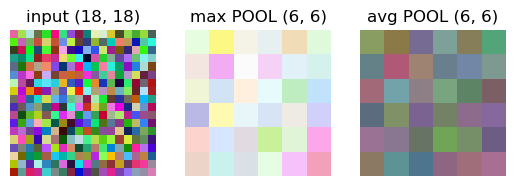

In [16]:
# testing
A_prev, max_params, avg_params = t7.pool_fwd_test()
A_maxpool, cache = pool_fwd(A_prev, max_params)
A_avgpool, _ = pool_fwd(A_prev, avg_params)
print("mean(A_maxpool) = {:.3f}".format(np.mean(A_maxpool)))
print("mean(A_avgpool) = {:.3f}".format(np.mean(A_avgpool)))
print("{}x{} CONV with stride {}".format(cache['n_f'], cache['n_f'], cache['stride']))

_, figs = plt.subplots(1, 3)
figs[0].set_title('input {}'.format(A_prev.shape[1:3]))
figs[1].set_title('max POOL {}'.format(A_maxpool.shape[1:3]))
figs[2].set_title('avg POOL {}'.format(A_avgpool.shape[1:3]))
figs[0].imshow(A_prev[0,:,:,:])
figs[1].imshow(A_maxpool[0,:,:,:])
figs[2].imshow(A_avgpool[0,:,:,:])
_ = [fig.axis('off') for _, fig in np.ndenumerate(figs)]

> ***Expected Output:***
>
> `mean(A_maxpool) = 0.900
mean(A_avgpool) = 0.501
3x3 CONV with stride 3`


## D. Pool Layer Backprop ##

Let's now implement the backward pass for the POOL layer for both max and average pooling modes. Even though a pooling layer has no parameters to update, we still need to backprop the gradient through the pooling layer in order to compute gradients for previous layers (typically a CONV layer).

### D.1. Pooling mask  ###

Let's first consider the max pooling mode. We must consider the location of the maximum values in the input maps, creating a mask slice from the pooling region. Note that it is possible to have multiple entries of the max value. In this case, we will scale the mask by the number of max values. This mask indicates input locations that affect the pooling output. Similarly we can define a pooling mask for the average pooling mode. In this case, all the values in the slice window affect the pooling output equally. So the mask will be a matrix of ones scaled by the average pooling number of elements.

> <font color='darkgreen'>**Exercise 8:**</font> Implement the function to create the pool mask for a given slice. <br>

In [17]:
def slice_mask(a_slice, pool_mode):
    """
    Creates a mask from input sclice
    
    Arguments:
    a_slice -- Array of shape (n_f, n_f)
    pool_mode -- String either 'max' or 'avg'
    
    Returns:
    mask -- Array of shape (n_f, n_f)
    """
    
    ### INPUT YOUR CODE HERE ### (5 lines)
    if pool_mode == 'max':
        mask = (a_slice == np.max(a_slice))
    elif pool_mode == 'avg': 
        mask = np.ones_like(a_slice) / a_slice.size
    mask = mask.astype(int)
    ### END OF YOUR CODE SEGMENT ###
    
    return mask

In [18]:
# testing
np.random.seed(2019) # for reproducibility
a_slice = np.round(10 * np.random.rand(2, 3))
print('a_slice:')
print('{}'.format(a_slice))
mask = slice_mask(a_slice, 'max')
print('max mask:')
print('{}'.format(mask))
mask = slice_mask(a_slice, 'avg')
print('avg mask:')
print('{}'.format(mask))

a_slice:
[[9. 4. 6.]
 [6. 9. 3.]]
max mask:
[[1 0 0]
 [0 1 0]]
avg mask:
[[0 0 0]
 [0 0 0]]


> ***Expected Output:***
>
> `a_slice:
[[9. 4. 6.]
 [6. 9. 3.]]
max mask:
[[0.5 0.  0. ]
 [0.  0.5 0. ]]
avg mask:
[[0.167 0.167 0.167]
 [0.167 0.167 0.167]]`


### D.2. POOL Layer Backprop ###
  
Let's now compute the backward propagation of the POOL layer. 

> <font color='darkgreen'>**Exercise 9:**</font> Implement the function below using four nested loops to compute the POOL layer backprop using the `slice_mask` function above to compute the mask to be mutliplied by the $dZ_{i,h,w,c}$ scalar using broadcasting.

In [25]:
# Pooling layer backward propagation
def pool_back(dA, cache):
    """
    Implements pooling backward propagation 
    
    Arguments:
    dA -- gradient of loss with respect to pooling layer output, same shape as A
    cache -- dictionary for backprop
        A_prev -- pool layer input
        stride -- integer
        n_f -- integer
        pool_mode -- string either 'max' or 'avg'
    
    Returns:
    dA_prev -- gradient of loss with respect to pooling layer input, same shape as A_prev
    """
    
    ### INPUT YOUR CODE HERE ### (7 lines)
    A_prev = cache['A_prev'] 
    stride = cache['stride'] 
    n_f = cache['n_f']
    pool_mode = cache['pool_mode']
    n, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    _, n_H, n_W, n_C = dA.shape
    dA_prev = np.zeros_like(A_prev)
    ### END OF YOUR CODE SEGMENT ###

    
    for i in range(n):                    # batch loop
        a_prev = A_prev[i, :, :, :]       # select training example from A_prev
        for h in range(n_H):              # height loop
            for w in range(n_W):          # width loop
                for c in range(n_C):      # channel loop
                    ### INPUT YOUR CODE HERE ### (5 lines)
                    h_range = slice(h*stride, h*stride+n_f)
                    w_range = slice(w*stride, w*stride+n_f)
                    a_prev_slice = A_prev[i, h_range, w_range, c]
                    mask = slice_mask(a_prev_slice,pool_mode)
                    dA_prev[i, h_range , w_range, c] += mask * dA[i, h, w, c]
                    ### END OF YOUR CODE SEGMENT ###

    assert(dA_prev.shape == A_prev.shape)    
    return dA_prev

max-pool: mean(dA_prev) = 0.055, std(dA_prev) = 0.184
avg-pool: mean(dA_prev) = 0.000, std(dA_prev) = 0.000


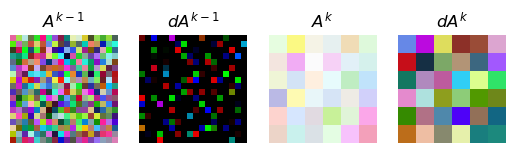

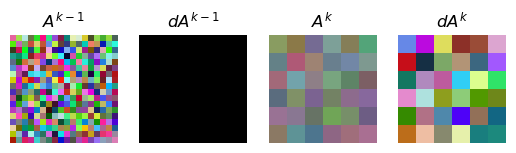

In [26]:
# testing
A_prev, max_params, avg_params = t7.pool_fwd_test()

A, cache = pool_fwd(A_prev, max_params)
dA = np.random.rand(*A.shape)
dA_prev = pool_back(dA, cache)
print("{}-pool: mean(dA_prev) = {:.3f}, std(dA_prev) = {:.3f}".format(cache['pool_mode'], np.mean(dA_prev), np.std(dA_prev)))

_, figs = plt.subplots(1, 4)
figs[0].imshow(A_prev[0,:,:,:])
figs[1].imshow(dA_prev[0,:,:,:])
figs[2].imshow(A[0,:,:,:])
figs[3].imshow(dA[0,:,:,:])
figs[0].set_title('$A^{k-1}$')
figs[1].set_title('$dA^{k-1}$')
figs[2].set_title('$A^{k}$')
figs[3].set_title('$dA^{k}$')
_ = [fig.axis('off') for _, fig in np.ndenumerate(figs)]

A, cache = pool_fwd(A_prev, avg_params)
dA_prev = pool_back(dA, cache)
print("{}-pool: mean(dA_prev) = {:.3f}, std(dA_prev) = {:.3f}".format(cache['pool_mode'], np.mean(dA_prev), np.std(dA_prev)))

_, figs = plt.subplots(1, 4)
figs[0].imshow(A_prev[0,:,:,:])
figs[1].imshow(dA_prev[0,:,:,:])
figs[2].imshow(A[0,:,:,:])
figs[3].imshow(dA[0,:,:,:])
figs[0].set_title('$A^{k-1}$')
figs[1].set_title('$dA^{k-1}$')
figs[2].set_title('$A^{k}$')
figs[3].set_title('$dA^{k}$')
_ = [fig.axis('off') for _, fig in np.ndenumerate(figs)]
# 

> ***Expected Output:***
>
> `max-pool: mean(dA_prev) = 0.055, std(dA_prev) = 0.184
avg-pool: mean(dA_prev) = 0.055, std(dA_prev) = 0.032`

## Final Remark ##

You now ready to create deep convolutional models stacking CONV and POOL layers. Note that our implementation is not fully vectorised (4 nested loops in forward and barckward propagation) and as a result training large models will be slow. Also we don't make use of massively parallel MAC achitectures as found in GPU. For this reason, we won't train any model with this code and will prefer to use deep learning frameworks such as tensorflow.keras or pytorch.nn.

-- EOF --